In [1]:
from musiccaps import load_musiccaps
import numpy as np
import torch
import re
import json


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/alexandrasouly/miniconda3/envs/muscaps/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_musiccaps(
    './music_data',
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True
)

Found cached dataset csv (/Users/alexandrasouly/.cache/huggingface/datasets/google___csv/google--MusicCaps-bedc2a0fd7888f2f/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


In [4]:
# Filter out those not downloaded
import os
filtered_ds = []
for song in ds:
    ytid = song['ytid'] + '.npy'
    if ytid in os.listdir('data/datasets/muscaps/audio'):
        filtered_ds.append(song)
print(len(filtered_ds))

5485


In [6]:
# Create json file
json_dict_list = []
for song in filtered_ds:
    token = re.sub(r'[^\w\s]','',song['caption']).lower().split(' ')
    json_dict = {}
    json_dict['track_id'] = song['ytid']
    json_dict['caption'] = {}
    json_dict['caption']['tokens'] = token
    json_dict['caption']['raw'] = song['caption']
    json_dict_list.append(json_dict)

with open("data/datasets/muscaps/muscaps_data.json", "w") as final:
   json.dump(json_dict_list, final)

In [7]:
# Make the train valid test split

with open('data/datasets/muscaps/split.json') as f:
    split_ds = json.load(f)
with open('data/datasets/muscaps/muscaps_data.json') as f:
    muscaps_ds = json.load(f)

train = []
valid = []
test = []
for song in muscaps_ds:
    if song['track_id'] in split_ds['train']:
        train.append(song)
    elif song['track_id'] in split_ds['valid']:
        valid.append(song)
    elif song['track_id'] in split_ds['test']:
        test.append(song)
    else:
        print( song['track_id'] )
with open('data/datasets/muscaps/dataset_train.json', 'w') as f:
    json.dump(train, f)
with open('data/datasets/muscaps/dataset_val.json', 'w') as f:
    json.dump(valid, f)
with open('data/datasets/muscaps/dataset_test.json', 'w') as f:
    json.dump(test, f)


136
{'track_id': 'Yt1czlnCUCg', 'caption': {'tokens': ['this', 'childrens', 'song', 'features', 'a', 'male', 'voice', 'singing', 'the', 'main', 'melody', 'this', 'is', 'accompanied', 'by', 'male', 'and', 'female', 'voices', 'singing', 'backing', 'vocals', 'in', 'harmony', 'this', 'has', 'a', 'call', 'and', 'response', 'technique', 'where', 'the', 'main', 'voice', 'sings', 'a', 'line', 'followed', 'by', 'the', 'response', 'by', 'the', 'choir', 'this', 'is', 'accompanied', 'by', 'percussion', 'playing', 'a', 'simple', 'beat', 'after', 'two', 'bars', 'the', 'instruments', 'pause', 'the', 'bass', 'plays', 'the', 'root', 'notes', 'of', 'the', 'chords', 'and', 'sliding', 'to', 'a', 'pause', 'at', 'the', 'end', 'of', 'the', 'bar', 'during', 'the', 'pause', 'the', 'voices', 'continue', 'to', 'sing', 'the', 'main', 'voice', 'sings', 'two', 'lines', 'and', 'the', 'choir', 'sings', 'the', 'third', 'line', 'with', 'the', 'main', 'voice', 'in', 'harmony', 'the', 'mood', 'of', 'this', 'song', 'is', 

(array([  2.,   1.,   0.,   1.,   1.,   2.,   4.,   5.,  10.,  18.,  21.,
         17.,  57.,  22.,  37.,  78.,  50.,  66., 140.,  78.,  75., 177.,
         95., 109., 238., 160., 161., 283., 148., 166., 261., 135., 145.,
        253., 143., 108., 213.,  96., 109., 181.,  96.,  78., 142.,  83.,
         84., 128.,  69.,  53., 118.,  56.,  48.,  84.,  51.,  45.,  76.,
         35.,  31.,  61.,  32.,  25.,  35.,  17.,  13.,  24.,  15.,  10.,
         17.,  15.,   9.,  13.,   9.,   3.,   7.,   7.,   2.,   7.,   2.,
          2.,   4.,   3.,   0.,   4.,   0.,   0.,   2.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([  3.  ,   4.33,   5.66,   6.99,   8.32,   9.65,  10.98,  12.31,
         13.64,  14.97,  16.3 ,  17.63,  18.96,  20.29,  21.62,  22.95,
         24.28,  25.61,  26.94,  28.27,  29.6 ,  30.93,  32.26,  33.59,
         34.92,  36.25,  37.58,  38.91,  40.24,  41.57,  42.9 ,  44.23,
         45.56,  46.89,  48.22

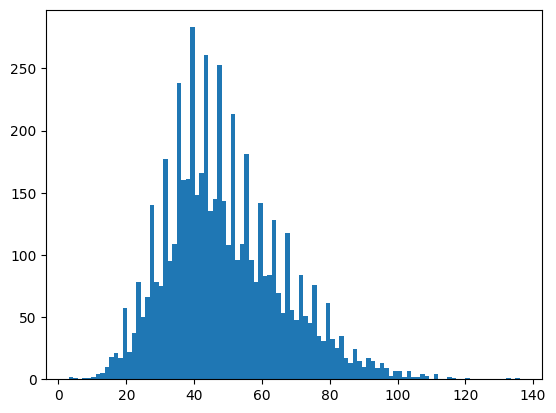

In [8]:
# Max length of 
max_len = 0

for song in muscaps_ds:
    song_len = len(song['caption']['tokens'])
    if song_len > max_len:
        max_len = song_len
        max_song = song
print(max_len)
print(max_song)

from collections import Counter
import matplotlib.pyplot as plt
song_lens = [len(song['caption']['tokens']) for song in muscaps_ds]
counts = Counter(song_lens)
plt.hist(song_lens, bins=100)